In [2]:
import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import wikipedia
import difflib
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

wikipedia.set_lang('en')



In [ ]:
from src.data import journalists as journos
from src.data import data_cleanup as dc
from src.topics import hashtag_analysis as ha

In [5]:
!pip install gensim==3.8.3

In [6]:
!pip install wikipedia

In [7]:
#import data

src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['tweet_id', 'text', 'hashtags']]], axis=0)
        pbar.update(1)
        
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data = data[data.text != '']

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [02:27<00:00,  3.68s/it]


In [8]:
hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

NameError: name 'ha' is not defined

In [ ]:
hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [ ]:
topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics.head(50)

In [ ]:
topics['keywords'][:50]

#### assign topics to tweets

In [ ]:
topics = [['covid19', 'lockdown', 'coronavirus', 'mentalhealth', 'healthcare'], 
['ai', 'ml', 'datascience', 'artificalintelligence'], 
['cybersecurity', 'iot', 'robotics', 'infosec'],
['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto']]

topics = [['covid19', 'lockdown', 'coronavirus'],
            ['ai', 'ml', 'datascience', 'artificalintelligence', 'machinelearning', 'bigdata'], 
            ['cybersecurity', 'iot', 'robotics', 'infosec'],
            ['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto', 'banking'],
            ['Brexit'],
            ['startup', 'startups'],
            ['china'],

In [6]:
def check_for_matches(tag_list, topic_list):
    '''
    
    '''
    matches = []
    
    # Compare list of hashtags in tweet against those in each topic
    potential_matches = [bool(set(tag_list).intersection(set(topic))) for topic in topics]
    if any(potential_matches):
        matches.extend([i for i in range(len(potential_matches)) if potential_matches[i]])
    else:
        matches.append(4)
    return matches

possible_topics = data['hashtags'].apply(lambda x: check_for_matches(eval(x), topics))

labelled_data = data.assign(topic_labels=possible_topics.values)
labelled_data['main_label'] = labelled_data['topic_labels'].apply(lambda x: x[0])
labelled_data

,tweet_id,text,hashtags,topic_labels,main_label
1,1293934001514848256,rt breaking via fbi to join beirut blast probe...,"['breaking', 'fbi', 'beirut', 'probe']",[4],4
2,1293580602055299072,rt breaking lebanon prosecutor to question sev...,"['breaking', 'beirutblast']",[4],4
6,1292021027543953408,rt according to the lebanese health ministry o...,['beirutblast'],[4],4
9,1291401752911257606,rt breaking imf urges lebanon to break reform ...,"['breaking', 'lebanon']",[4],4
12,1291331749956509698,macron says will pitch new political deal to l...,['lebanon'],[4],4
...,...,...,...,...,...
87365,1270406159355334656,rt another fascinating panel this afternoon th...,"['trust', 'technology']",[4],4
87379,1268578990220029953,rt join this cogx panel to hear the latest exp...,['cogx2020'],[4],4
87437,1260516465435906050,rt join us today bst to discuss whether a join...,"['covid19uk', 'contacttracing']",[4],4
87439,1260119164502659072,rt could ai get us out of lockdown a group of ...,['ai'],[1],1


In [8]:
sample_df = pd.DataFrame()
for label in range(0,5):
    rnd_idx = random.sample(range(labelled_data[labelled_data['main_label']==label].shape[0]), 5000)
    sample_df = pd.concat([sample_df, labelled_data[labelled_data['main_label']==label].iloc[rnd_idx]], axis=0)
sample_df

,tweet_id,text,hashtags,topic_labels,main_label
57436,1285676139474759687,rt now more than ever the health of one person...,['covid19'],[0],0
36739,1291286419810529281,rt did covid change your security strategies i...,"['strategy', 'informationsecurity', 'covid19']",[0],0
55592,1288901957487271936,live maj gen payne amp brig gen friedrichs hol...,['covid19'],[0],0
4860,1283061944186892288,this mit robot can disinfect a warehouse floor...,"['covid19', 'logistics', 'automation', 'techne...",[0],0
39502,1285862622303326208,of our esg related creditrating actions during...,"['esg', 'creditrating', 'covid19', 'esgpulse']",[0],0
...,...,...,...,...,...
56377,897845712003706880,lovely evening for a saffron spritz railhousec...,"['railhousecafe', 'ridinghousecafe', 'housecaf...",[4],4
77496,1288123413748318217,the recent twitter hack targeted blue tick ver...,"['insiderthreat', 'smes', 'smeuk']",[4],4
67548,1255970386195382272,rt ft us stocks on brink of best month since t...,['tomorrowspaperstoday'],[4],4
496,688843288095363072,rt expect some pretty wild accusations to be t...,"['russia', 'litvinenko']",[4],4


In [9]:
sample_df['main_label'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
grouped = sample_df.groupby('main_label')['text'].agg(' '.join)
grouped


main_label
0    rt now more than ever the health of one person...
1    ai platform detects power grid flaws and wildf...
2    lifars data security awareness resources knowl...
3    rt largest fintech deals in europe so far some...
4    national trust joins victims of blackbaud cybe...
Name: text, dtype: object

In [11]:
!pip install wordcloud

In [12]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [93]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('image_x.jpeg')
    plt.show()
    

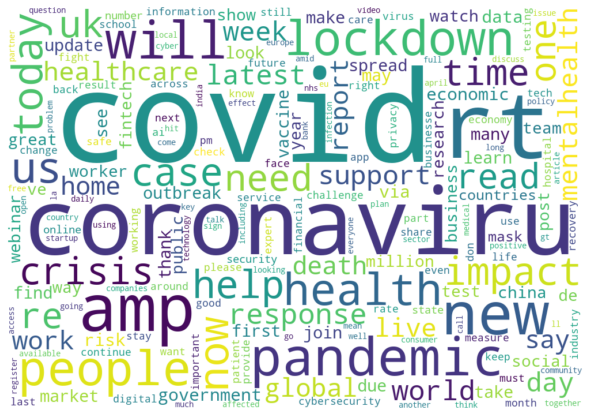

In [94]:
wordcloud_plot(grouped[0])

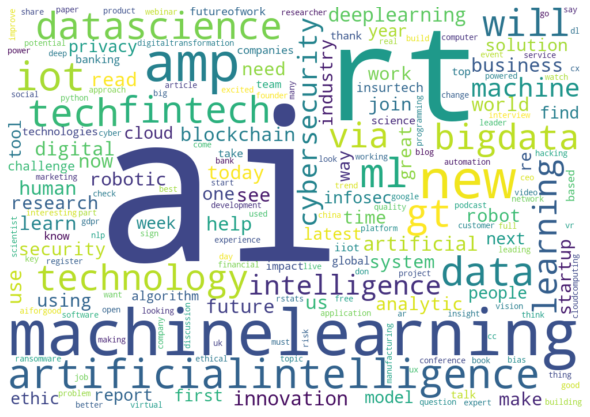

In [95]:
wordcloud_plot(grouped[1])

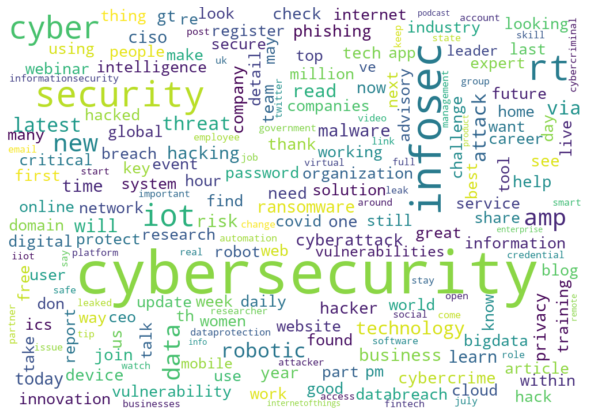

In [96]:
wordcloud_plot(grouped[2])

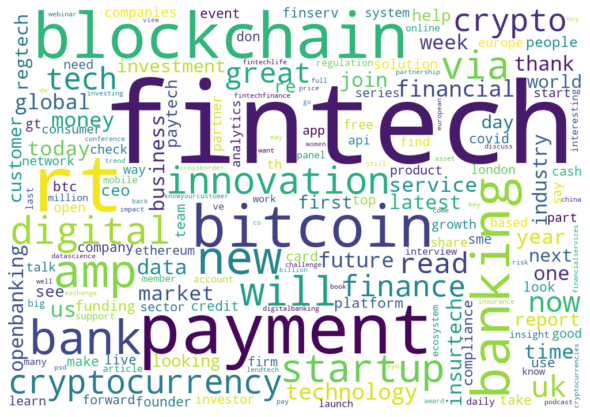

In [98]:
wordcloud_plot(grouped[3])

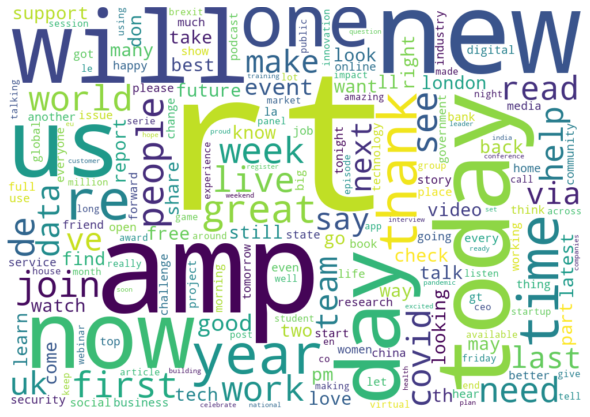

In [99]:
wordcloud_plot(grouped[4])

In [22]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)
#            if (len(word) >= min_characters_word) : tokens.append(word)
    return tokens


# Pre-process training data

Adapted from Martin's code ref:  https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [23]:
min_characters_sent = 3   #Min characters in a paragraph (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

In [24]:
%time labelled_data['tokens'] = labelled_data['text'].apply(lambda x: tokenize_text(str(x)))

Wall time: 6min 6s


In [25]:
train, test = train_test_split(labelled_data[['text', 'main_label', 'tokens']], test_size=test_size, random_state=42)

train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)

# Apply models

# # Distributed bag of words


In [26]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [27]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=1, min_count=2, sample=0, workers=cores) #My optimised values

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████| 578212/578212 [00:00<00:00, 2311428.40it/s]


In [28]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████| 578212/578212 [00:01<00:00, 455401.40it/s]


Wall time: 1h 29min 57s


In [29]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [30]:
# Distributed Bag of Words (DBOW) model

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg_dbow = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dbow.fit(X_train, y_train)
y_pred = logreg_dbow.predict(X_test)
print('xgb_model_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


xgb_model_dbow Testing accuracy 0.8771185854421185
xgb_model_dbow Testing F1 score: 0.8449997068981191


# Distributed memory


In [31]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=500, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████| 578212/578212 [00:01<00:00, 544385.33it/s]


In [32]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|█████████████████████████████████████████████████████████████████████| 578212/578212 [00:00<00:00, 1156607.65it/s]


Wall time: 2h 8min 20s


In [33]:
# Distributed Memory (DM) model

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg_dmm = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dmm.fit(X_train, y_train)
y_pred = logreg_dmm.predict(X_test)

print('model_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

model_dmm Testing accuracy 0.8761639249000374
model_dmm Testing F1 score: 0.8209760142381699


# Combined model pairing

In [34]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [35]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [36]:
# Model Pairing method

y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)
logreg_new = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)
print('xgb_model_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


xgb_model_new Testing accuracy 0.8809026384603678
xgb_model_new Testing F1 score: 0.8527281772877314


In [218]:
sim = model_dmm.n_similarity(['covid'], ['coronavirus'])
sim2 = model_dmm.n_similarity(['coronavirus'], ['pandemic'])
sim3 = model_dmm.n_similarity(['coronavirus'], ['cybersecurity'])
sim4 = model_dmm.n_similarity(['cybersecurity'], ['trump'])

print("{:.4f}".format(sim))
print("{:.4f}".format(sim2))
print("{:.4f}".format(sim3))
print("{:.4f}".format(sim4))

0.3702
0.1049
0.0361
-0.0027


C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.
C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  
C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the 

In [277]:
my_list = ['jenkins', 'most', 'popular', 'software', 'deployment', 'server', 'the', 'world', 
                                  'learn', 'from', 'our', 'cto', 'about', 'how', 'hackers', 'look', 'misconfigured',
                                  'jenkins', 'servers', 'for', 'new', 'places', 'attack', 'jenkins', 'cyber',
                                  'insurance', 'cybersecurity', 'atbay']
infer_vector = model_dmm.infer_vector(my_list)

similar_documents = model_dmm.docvecs.most_similar([infer_vector])
similar_documents


[('4', 0.19703948497772217),
 ('2', 0.08782587945461273),
 ('3', 0.06855292618274689),
 ('0', 0.06034817919135094),
 ('1', 0.036130599677562714)]

# Apply to tweets

In [37]:
def get_vectors_apply(model, docs_to_classify):
    sents = docs_to_classify.values
    regressors = [model.infer_vector(doc.words, steps=20) for doc in sents]
    return regressors

In [38]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text)) #remove urls
    text = re.sub(r'\S+\.com\S+','',str(text)) #remove urls
    text = re.sub(r'\@\w+','',str(text)) #remove mentions
    text =re.sub(r'\#','',str(text)) #remove hashtags
    text = re.findall(r'[A-Za-z]+',str(text))
    text = ' '.join(text) 
    return text

In [41]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
classifier_model = logreg_new
model = model_new

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['clean_tweet']), tags=[r.screen_name]), axis=1)
        X_test = get_vectors_apply(model, test_tagged)
        df['y_pred'] = classifier_model.predict(X_test)
        y_pred_score = classifier_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=classifier_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv('tweets_trained_topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv('tweets_trained_all_topics_modelled_'+str(i)+'.csv', index=False)
        print(df4.head())
        pbar.update(1)
        i = i+1


Files:   2%|█▊                                                                       | 1/40 [06:14<4:03:10, 374.11s/it]

              tweet_id   screen_name  \
0  1294203275043110912  robahusseini   
1  1293934001514848256  robahusseini   
2  1293580602055299072  robahusseini   
3  1293160356240592896  robahusseini   
4  1292555363393458179  robahusseini   

                                                text y_pred     score  \
0  Beirut blast who knew what when My latest for ...      4  0.942462   
1  RT Breaking via FBI to join Beirut blast probe...      4  0.984494   
2  RT BREAKING Lebanon prosecutor to question sev...      4  0.979786   
3  When the boy saw blood on his feet he started ...      4  0.973620   
4                                                 RT      4  0.896734   

          0         1         2         3         4     score  
0  0.005204  0.011274  0.013995  0.027065  0.942462  0.942462  
1  0.004588  0.005288  0.001591  0.004039  0.984494  0.984494  
2  0.013581  0.002924  0.001710  0.002000  0.979786  0.979786  
3  0.007274  0.003093  0.000272  0.015741  0.973620  0.973620  


Files:   5%|███▋                                                                     | 2/40 [12:39<3:59:03, 377.46s/it]

              tweet_id     screen_name  \
0  1275530996822269953  lachcartwright   
1  1275049519592456192  lachcartwright   
2  1275042365875662848  lachcartwright   
3  1274841046640443393  lachcartwright   
4  1274840726791229440  lachcartwright   

                                                text y_pred     score  \
0  Trump Goes to Court to Block Niece s Tell All ...      4  0.996785   
1  RT New President Trump says niece not allowed ...      4  0.988739   
2  RT Steven Bannon s platform to air COVID consp...      4  0.551335   
3  RT One of the ways we knew that Mary had signe...      4  0.960892   
4  Donald Trump Confirms Niece Mary Trump Signed ...      4  0.964393   

          0         1         2         3         4     score  
0  0.002484  0.000202  0.000274  0.000255  0.996785  0.996785  
1  0.003110  0.002443  0.002158  0.003550  0.988739  0.988739  
2  0.397706  0.007856  0.020749  0.022354  0.551335  0.551335  
3  0.015285  0.006364  0.008982  0.008478  0.960892 

Files:   8%|█████▍                                                                   | 3/40 [18:39<3:49:34, 372.28s/it]

              tweet_id  screen_name  \
0  1296173525712109569  robmccargow   
1  1296113331405807626  robmccargow   
2  1296112454490087427  robmccargow   
3  1296106449395953665  robmccargow   
4  1296103329244819456  robmccargow   

                                                text y_pred     score  \
0  AI Can Make Music Screenplays and Poetry What ...      4  0.994780   
1  Yes indeed He s a bit hit amp miss with the ol...      4  0.773374   
2                                     Yes can t wait      4  0.988412   
3                       Ticks the home schooling box      4  0.972872   
4  Good shout One I ve been meaning to see but ha...      4  0.963341   

          0         1         2         3         4     score  
0  0.000758  0.002663  0.000478  0.001321  0.994780  0.994780  
1  0.037572  0.094094  0.083738  0.011221  0.773374  0.773374  
2  0.007675  0.002803  0.000168  0.000941  0.988412  0.988412  
3  0.019507  0.001609  0.004273  0.001740  0.972872  0.972872  
4  0.0

Files:  10%|███████▎                                                                 | 4/40 [24:30<3:39:27, 365.75s/it]

             tweet_id screen_name  \
0  325193537857654785    eitanjan   
1  324833628762804224    eitanjan   
2  253851884530565120    eitanjan   
3  251309203837313024    eitanjan   
4  251284731956707328    eitanjan   

                                                text y_pred     score  \
0  Here I am on Sky I ll be on Sky News Swipe ton...      4  0.997997   
1  RT Just heard we ve been named Games Law Firm ...      4  0.982244   
2  RT I m standing for election to the BIMA Execu...      4  0.976696   
3  Monetisation of social gambling games is up to...      4  0.924985   
4  When will social gambling be regulated Apparen...      4  0.918989   

          0         1         2         3         4     score  
0  0.001453  0.000295  0.000014  0.000242  0.997997  0.997997  
1  0.004421  0.003475  0.005771  0.004088  0.982244  0.982244  
2  0.005188  0.006278  0.002418  0.009421  0.976696  0.976696  
3  0.009118  0.015300  0.012113  0.038484  0.924985  0.924985  
4  0.004376  0.031

Files:  12%|█████████▏                                                               | 5/40 [30:27<3:31:49, 363.13s/it]

              tweet_id   screen_name  \
0  1295356925337407488  prestonkanak   
1  1294401148409884672  prestonkanak   
2  1290276764816568320  prestonkanak   
3  1288931973797298176  prestonkanak   
4  1288898494380429317  prestonkanak   

                                                text y_pred     score  \
0                                   Where you at now      4  0.896381   
1                               Ain t that the truth      4  0.994582   
2  Your new camera bag looks great Buying once it...      4  0.934705   
3  Was this for z I ve got other dummy batteries ...      4  0.989813   
4  Meant to put up a corrected one specifying z d...      4  0.900902   

          0         1         2         3         4     score  
0  0.043741  0.018781  0.028237  0.012859  0.896381  0.896381  
1  0.000141  0.004289  0.000777  0.000210  0.994582  0.994582  
2  0.029254  0.021031  0.012911  0.002100  0.934705  0.934705  
3  0.000939  0.002064  0.002127  0.005057  0.989813  0.989813  


Files:  15%|██████████▉                                                              | 6/40 [36:25<3:24:57, 361.70s/it]

             tweet_id      screen_name  \
0  536800203115085824  europevfacebook   
1  536798363896016896  europevfacebook   
2  536794052185038848  europevfacebook   
3  536089813997617152  europevfacebook   
4  535100907760156673  europevfacebook   

                                                text y_pred     score  \
0  Sammelklage Facebook bestreitet Gesch ftsf hig...      4  0.999378   
1  RT Logics of Facebook customers could not sue ...      4  0.838800   
2  Facebook contests legal competence of its user...      4  0.901769   
3  RT Schrems In US there s no law but there is e...      4  0.674831   
4  RT Termin mit der es wagte eine Klage gegen ei...      4  0.908379   

          0         1         2         3         4     score  
0  0.000320  0.000086  0.000209  0.000007  0.999378  0.999378  
1  0.089606  0.040074  0.016282  0.015238  0.838800  0.838800  
2  0.016796  0.024538  0.038328  0.018570  0.901769  0.901769  
3  0.003623  0.026142  0.005053  0.290351  0.674831 

Files:  18%|████████████▊                                                            | 7/40 [42:19<3:17:35, 359.27s/it]

              tweet_id   screen_name  \
0  1267746361262444544  amitahanspal   
1  1250448399196971013  amitahanspal   
2  1216800306744393731  amitahanspal   
3  1213430701401530369  amitahanspal   
4  1144342989029945344  amitahanspal   

                                                text y_pred     score  \
0  RT How will Covid shift attitudes to AI and da...      4  0.890218   
1  You re not getting out of the k I m about to n...      4  0.965189   
2  Scale of how excited do you reckon the marketi...      4  0.928432   
3  This effort to reduce plastic needs some more ...      4  0.951622   
4  RT Here at our techlash event with and Jon Cro...      4  0.968961   

          0         1         2         3         4     score  
0  0.057091  0.029823  0.018492  0.004376  0.890218  0.890218  
1  0.024089  0.007573  0.001994  0.001155  0.965189  0.965189  
2  0.010903  0.026817  0.001115  0.032732  0.928432  0.928432  
3  0.019719  0.006470  0.019311  0.002877  0.951622  0.951622  


Files:  20%|██████████████▌                                                          | 8/40 [48:17<3:11:26, 358.96s/it]

              tweet_id   screen_name  \
0  1293802732642418689  josephgeha16   
1  1293792589649305603  josephgeha16   
2  1293792465791496192  josephgeha16   
3  1293783640279678976  josephgeha16   
4  1293782372597424133  josephgeha16   

                                                text y_pred     score  \
0  Here s Supt CJ Cammack on one side of the boar...      4  0.690246   
1  This is not the first Fremont school board mee...      4  0.896004   
2  Three of five Fremont Unified School Board mem...      4  0.905806   
3             Do you think it s materially different      4  0.978968   
4                                                NaN      4  0.952644   

          0         1         2         3         4     score  
0  0.292443  0.008791  0.004882  0.003638  0.690246  0.690246  
1  0.003046  0.009928  0.004187  0.086836  0.896004  0.896004  
2  0.088031  0.003288  0.001587  0.001289  0.905806  0.905806  
3  0.013256  0.001992  0.002706  0.003079  0.978968  0.978968  


Files:  22%|████████████████▍                                                        | 9/40 [54:30<3:07:43, 363.34s/it]

              tweet_id screen_name  \
0  1296131556059172865   padmasree   
1  1296106551401275394   padmasree   
2  1296092100530810887   padmasree   
3  1295198460862291968   padmasree   
4  1295088619921661952   padmasree   

                                                text y_pred     score  \
0  Yes Not be mention dealing with new realities ...      4  0.874418   
1                                     Omg Can t wait      4  0.992412   
2                    Even if the tables are ft apart      4  0.979040   
3  If you are a manga fan listen to and their pod...      4  0.923929   
4                                            Exactly      4  0.898818   

          0         1         2         3         4     score  
0  0.076651  0.016942  0.022114  0.009874  0.874418  0.874418  
1  0.006674  0.000477  0.000046  0.000391  0.992412  0.992412  
2  0.009860  0.002819  0.000839  0.007443  0.979040  0.979040  
3  0.016603  0.019592  0.034261  0.005615  0.923929  0.923929  
4  0.042552 

Files:  25%|█████████████████▌                                                    | 10/40 [1:00:38<3:02:21, 364.71s/it]

              tweet_id    screen_name  \
0  1287582419282006018  itsreallynick   
1  1287465006230102017  itsreallynick   
2  1287009418861830144  itsreallynick   
3  1287007372750315525  itsreallynick   
4  1287005161693552641  itsreallynick   

                                                text y_pred     score  \
0  We ve been improving our language as well I ve...      4  0.704635   
1  RT This PoC maldoc abuses registry keys for pe...      4  0.640142   
2  It surprises me why so many people put the val...      4  0.933559   
3  Teaching incident amp evidence documentation i...      4  0.862469   
4  RT It is kind of funny almost every incident r...      4  0.947861   

          0         1         2         3         4     score  
0  0.008212  0.136149  0.133347  0.017657  0.704635  0.704635  
1  0.007548  0.035986  0.315197  0.001127  0.640142  0.640142  
2  0.016545  0.017950  0.027997  0.003948  0.933559  0.933559  
3  0.103329  0.001918  0.021522  0.010762  0.862469  0.862

Files:  28%|███████████████████▎                                                  | 11/40 [1:06:32<2:54:42, 361.48s/it]

              tweet_id  screen_name  \
0  1293879335284285441  icsr_centre   
1  1293543038816526340  icsr_centre   
2  1291358515458641922  icsr_centre   
3  1291342479539810306  icsr_centre   
4  1290621254198673409  icsr_centre   

                                                text y_pred     score  \
0  RT Director said in a Twitter post that many g...      4  0.882112   
1  RT Data from shows an estimated men women and ...      4  0.889201   
2  RT Throw back to my grumpy behind the scenes s...      4  0.985538   
3  She was a white western convert She painted he...      4  0.967277   
4  While the implications of adopting the lira wh...      4  0.597854   

          0         1         2         3         4     score  
0  0.044397  0.022800  0.008580  0.042111  0.882112  0.882112  
1  0.073909  0.006236  0.003773  0.026880  0.889201  0.889201  
2  0.006940  0.002263  0.000605  0.004655  0.985538  0.985538  
3  0.019534  0.010707  0.001651  0.000831  0.967277  0.967277  
4  0.2

Files:  30%|█████████████████████                                                 | 12/40 [1:17:57<3:33:59, 458.54s/it]

              tweet_id screen_name text y_pred     score         0         1  \
0  1285253093974773767   malektael  NaN      4  0.940677  0.053579  0.003959   
1  1285252381584826373   malektael  NaN      4  0.933970  0.062680  0.002942   
2  1285251735515168774   malektael  NaN      4  0.969712  0.001880  0.024922   
3  1285251616363425794   malektael  NaN      4  0.941135  0.048438  0.007219   
4  1285248544346189824   malektael  NaN      4  0.950317  0.045718  0.002006   

          2         3         4     score  
0  0.001381  0.000404  0.940677  0.940677  
1  0.000273  0.000135  0.933970  0.933970  
2  0.003245  0.000241  0.969712  0.969712  
3  0.001575  0.001633  0.941135  0.941135  
4  0.001821  0.000139  0.950317  0.950317  


Files:  32%|██████████████████████▊                                               | 13/40 [1:34:02<4:34:37, 610.27s/it]

              tweet_id screen_name  \
0  1296144127613173760     sgurman   
1  1296131314895200259     sgurman   
2  1296120504810602496     sgurman   
3  1295831640132988930     sgurman   
4  1295800844512886789     sgurman   

                                                text y_pred     score  \
0  RT A media business tied to Steve Bannon and G...      4  0.961869   
1  RT Liberal justices are voting to uphold publi...      4  0.961304   
2  Barr says more than arrests have been made so ...      4  0.995586   
3  RT Attorney General Bill Barr spent time in De...      4  0.943721   
4                                              Jesus      4  0.900947   

          0         1         2         3         4     score  
0  0.020467  0.002227  0.003697  0.011740  0.961869  0.961869  
1  0.007401  0.026186  0.001823  0.003287  0.961304  0.961304  
2  0.001780  0.000243  0.000994  0.001397  0.995586  0.995586  
3  0.045782  0.001385  0.003001  0.006111  0.943721  0.943721  
4  0.041533 

Files:  35%|████████████████████████▌                                             | 14/40 [1:48:36<4:58:48, 689.54s/it]

              tweet_id screen_name  \
0  1296150848645496840  pgmcnamara   
1  1296033802112962560  pgmcnamara   
2  1296028917652959234  pgmcnamara   
3  1296028496704286720  pgmcnamara   
4  1296028424188895233  pgmcnamara   

                                                text y_pred     score  \
0  Now THIS is how to rock a backdrop Both amp wi...      4  0.973707   
1  Or I just get comfortable with creases and laz...      4  0.980033   
2             Our viewers are in for a treat tonight      4  0.963558   
3                                                 Oh      4  0.896734   
4                                                NaN      4  0.927748   

          0         1         2         3         4     score  
0  0.010200  0.005476  0.002301  0.008316  0.973707  0.973707  
1  0.004481  0.003384  0.010283  0.001820  0.980033  0.980033  
2  0.025288  0.006597  0.000589  0.003967  0.963558  0.963558  
3  0.043099  0.019143  0.027970  0.013054  0.896734  0.896734  
4  0.053185 

Files:  38%|██████████████████████████▎                                           | 15/40 [2:03:02<5:09:19, 742.38s/it]

              tweet_id     screen_name  \
0  1288893003151470592  courier_dundee   
1  1288867965283135488  courier_dundee   
2  1288852867273486337  courier_dundee   
3  1288767930813968384  courier_dundee   
4  1288712562905776128  courier_dundee   

                                                text y_pred     score  \
0  Popular Dundee to Edinburgh Airport bus servic...      4  0.972848   
1  Dundee schools said to be almost ready for pup...      4  0.970394   
2  Back to school What safety measures will be re...      4  0.969427   
3  Dundee s public toilets reopening after four m...      4  0.767356   
4  LIVE UPDATES All the latest news from Tayside ...      4  0.934681   

          0         1         2         3         4     score  
0  0.022492  0.002022  0.002155  0.000483  0.972848  0.972848  
1  0.021798  0.001809  0.002157  0.003843  0.970394  0.970394  
2  0.011901  0.008227  0.006708  0.003738  0.969427  0.969427  
3  0.213986  0.009913  0.007400  0.001345  0.767356 

Files:  40%|████████████████████████████                                          | 16/40 [2:16:39<5:05:54, 764.78s/it]

              tweet_id screen_name  \
0  1296200771000848385    newsweek   
1  1296200199963058178    newsweek   
2  1296195487968747520    newsweek   
3  1296192833565540352    newsweek   
4  1296189218537054208    newsweek   

                                                text y_pred     score  \
0  Muslim ICE detainees being served pork despite...      4  0.977655   
1  Virtual caucuses bring in record digital audie...      4  0.901972   
2  Ex FBI lawyer admits to doctoring key email in...      4  0.930634   
3  Amazon working to remove Joe and the Hoe T shi...      4  0.956186   
4  Colbert mocks Bill Clinton for criticizing Tru...      4  0.997792   

          0         1         2         3         4     score  
0  0.008950  0.000945  0.004370  0.008080  0.977655  0.977655  
1  0.022577  0.006751  0.004432  0.064267  0.901972  0.901972  
2  0.004980  0.018749  0.014419  0.031218  0.930634  0.930634  
3  0.022578  0.003983  0.009991  0.007262  0.956186  0.956186  
4  0.001844 

Files:  42%|█████████████████████████████▊                                        | 17/40 [2:30:00<4:57:18, 775.61s/it]

              tweet_id   screen_name  \
0  1272104447217471488  tadhgenright   
1  1272102646980239360  tadhgenright   
2  1272102105453649921  tadhgenright   
3  1270363629393793030  tadhgenright   
4  1270361256634040323  tadhgenright   

                                                text y_pred     score  \
0  British customers really getting the better en...      4  0.927938   
1        More evidence that s govt is totally badass      4  0.787847   
2  What a great story for your birthday Happy bir...      4  0.985282   
3                                      No I have not      4  0.896734   
4  I need to make corporation tax VAT and NI paym...      4  0.925449   

          0         1         2         3         4     score  
0  0.056468  0.001900  0.004163  0.009530  0.927938  0.927938  
1  0.197490  0.004012  0.002721  0.007929  0.787847  0.787847  
2  0.008204  0.000239  0.002405  0.003871  0.985282  0.985282  
3  0.043099  0.019143  0.027970  0.013054  0.896734  0.896734  


Files:  45%|███████████████████████████████▌                                      | 18/40 [2:44:12<4:52:49, 798.62s/it]

             tweet_id   screen_name  \
0  993765742209327104  jiten_bansal   
1  992292977434284032  jiten_bansal   
2  954341181009244160  jiten_bansal   
3  899908919845281792  jiten_bansal   
4  826697388106665986  jiten_bansal   

                                                text y_pred     score  \
0  I just published New Products for Frontend Dev...      4  0.923030   
1  I just published free and essential products t...      4  0.881194   
2                             New Products By Google      4  0.897826   
3  AllTabs is featured at producthunt producthunt...      4  0.977221   
4  I just published How to add Add to Homescreen ...      4  0.909714   

          0         1         2         3         4     score  
0  0.034308  0.016620  0.009156  0.016887  0.923030  0.923030  
1  0.048348  0.006528  0.050824  0.013106  0.881194  0.881194  
2  0.041797  0.019009  0.027575  0.013792  0.897826  0.897826  
3  0.001096  0.009192  0.008694  0.003798  0.977221  0.977221  
4  0.0

Files:  48%|█████████████████████████████████▎                                    | 19/40 [2:57:58<4:42:21, 806.73s/it]

              tweet_id screen_name  \
0  1291537281631883267  rachelking   
1  1291449723191164929  rachelking   
2  1291421643957567490  rachelking   
3  1291420027464437760  rachelking   
4  1291401930212769792  rachelking   

                                                text y_pred     score  \
0              Who is NOT at La Quinta at this point      4  0.997401   
1  RT so Bon Appetit would rather destroy an incr...      4  0.904310   
2  Not shocking but perpetually disappointing It ...      4  0.871521   
3  Even though I do like the I Voted sticker at p...      4  0.923013   
4  RT This is actually what draining the swamp lo...      4  0.989042   

          0         1         2         3         4     score  
0  0.000861  0.000507  0.000846  0.000384  0.997401  0.997401  
1  0.011576  0.068089  0.010414  0.005611  0.904310  0.904310  
2  0.068954  0.009686  0.033638  0.016201  0.871521  0.871521  
3  0.028245  0.016587  0.005105  0.027050  0.923013  0.923013  
4  0.002246 

Files:  50%|███████████████████████████████████                                   | 20/40 [3:12:34<4:35:50, 827.52s/it]

              tweet_id    screen_name  \
0  1296184187720994816  therealmrbenn   
1  1296168849797152770  therealmrbenn   
2  1296168476160208896  therealmrbenn   
3  1296168388146978816  therealmrbenn   
4  1296162277851369473  therealmrbenn   

                                                text y_pred     score  \
0  Your replies to this are Fabulous Thank you Mi...      4  0.992407   
1  David McKee gave the name William in interview...      4  0.984823   
2                                           Fabulous      4  0.899498   
3                                           Fabulous      4  0.899498   
4                                           Fabulous      4  0.899498   

          0         1         2         3         4     score  
0  0.003255  0.001783  0.000719  0.001836  0.992407  0.992407  
1  0.003973  0.005645  0.001934  0.003625  0.984823  0.984823  
2  0.042203  0.018676  0.026350  0.013273  0.899498  0.899498  
3  0.042203  0.018676  0.026350  0.013273  0.899498  0.899

Files:  52%|████████████████████████████████████▊                                 | 21/40 [3:27:52<4:30:42, 854.89s/it]

             tweet_id screen_name  \
0  760848785455079424    iamfoxes   
1  760588088133373952    iamfoxes   
2  760547479225978880    iamfoxes   
3  760533043740286976    iamfoxes   
4  760527985040625664    iamfoxes   

                                                text y_pred     score  \
0  RT s A Head Of Dreams Tour w amp is here TONIG...      4  0.965841   
1                                      Hahah amazing      4  0.995334   
2  I m playing s V st birthday party in weeks Las...      4  0.966415   
3                                                NaN      4  0.973077   
4                     That s both hilarious but also      4  0.976361   

          0         1         2         3         4     score  
0  0.010622  0.003826  0.001714  0.017998  0.965841  0.965841  
1  0.003671  0.000282  0.000533  0.000180  0.995334  0.995334  
2  0.004895  0.005043  0.008660  0.014986  0.966415  0.966415  
3  0.019208  0.004342  0.003054  0.000319  0.973077  0.973077  
4  0.011114  0.001

Files:  55%|██████████████████████████████████████▌                               | 22/40 [3:42:20<4:17:38, 858.79s/it]

              tweet_id screen_name  \
0  1295808433644605440    80s_kidz   
1  1295805986452705280    80s_kidz   
2  1295429466026582016    80s_kidz   
3  1295078908061265922    80s_kidz   
4  1295069834879926273    80s_kidz   

                                                text y_pred     score  \
0  Today would ve been Patrick Swayzes th birthda...      4  0.992773   
1                               Who remembers Scully      4  0.984423   
2  Mind absolutely blown I never knew this This i...      4  0.980916   
3                        Who loved watching SuperTed      4  0.965865   
4  Sunday bath night Vosene shampoo just out of shot      4  0.992098   

          0         1         2         3         4     score  
0  0.004262  0.000711  0.001728  0.000526  0.992773  0.992773  
1  0.007716  0.002035  0.004700  0.001126  0.984423  0.984423  
2  0.002745  0.004593  0.009681  0.002065  0.980916  0.980916  
3  0.023039  0.005572  0.001337  0.004186  0.965865  0.965865  
4  0.005043 

Files:  57%|████████████████████████████████████████▎                             | 23/40 [3:56:37<4:03:09, 858.23s/it]

              tweet_id   screen_name  \
0  1291646512687190019  joemenninger   
1  1291645451532476417  joemenninger   
2  1291631413146587136  joemenninger   
3  1291613795643777024  joemenninger   
4  1291496028068347913  joemenninger   

                                                text y_pred     score  \
0  Two local banks from Trier invest mn Euros in ...      4  0.878491   
1  We also made a short appearance in the tech po...      4  0.847308   
2  Deutsche Bank takes double hit in digital stra...      4  0.564300   
3  Henkel buys of beauty product brand HelloBody ...      4  0.968865   
4  Zalando sells bonds worth bn Germany TechNews ...      4  0.932669   

          0         1         2         3         4     score  
0  0.022949  0.011589  0.009548  0.077422  0.878491  0.878491  
1  0.030355  0.030090  0.000977  0.091270  0.847308  0.847308  
2  0.014479  0.028902  0.009032  0.383286  0.564300  0.564300  
3  0.009551  0.007284  0.003706  0.010594  0.968865  0.968865  


Files:  60%|██████████████████████████████████████████                            | 24/40 [4:09:59<3:44:20, 841.31s/it]

             tweet_id   screen_name  \
0  422284399141748736  englandslane   
1  421386331097669632  englandslane   
2  421070477365612544  englandslane   
3  418374877591400448  englandslane   
4  417803659947569152  englandslane   

                                                text y_pred     score  \
0      RT Good morning Primrose Hill brrrrrrr thanks      4  0.968457   
1  I ll be missing the sirens and security of hav...      4  0.985952   
2  RT One last look around Belsize Fire Station a...      4  0.963308   
3                                  HAPPY NEW YEAR NW      4  0.898531   
4  I got some plasticine for Christmas I didn t k...      4  0.931815   

          0         1         2         3         4     score  
0  0.018046  0.004282  0.001989  0.007226  0.968457  0.968457  
1  0.006674  0.001914  0.004367  0.001094  0.985952  0.985952  
2  0.014871  0.006285  0.011702  0.003833  0.963308  0.963308  
3  0.042988  0.018788  0.027007  0.012687  0.898531  0.898531  
4  0.0

Files:  62%|███████████████████████████████████████████▊                          | 25/40 [4:24:06<3:30:42, 842.87s/it]

              tweet_id      screen_name  \
0  1294670687630761992  bankjobpictures   
1  1290632143815749632  bankjobpictures   
2  1288913134460325889  bankjobpictures   
3  1284631681559822336  bankjobpictures   
4  1280553962576457730  bankjobpictures   

                                                text y_pred     score  \
0  RT From comes the Bank Job book A white knuckl...      4  0.957188   
1  RT Art becomes action when two artists launch ...      4  0.912385   
2  You don t choose to be born into an income bra...      4  0.988560   
3  RT This is a massive scandal perhaps the bigge...      4  0.883248   
4  RT Love these proofs BANK JOB is the story of ...      4  0.944896   

          0         1         2         3         4     score  
0  0.008688  0.009706  0.017576  0.006843  0.957188  0.957188  
1  0.045851  0.015911  0.006371  0.019481  0.912385  0.912385  
2  0.000023  0.003366  0.006213  0.001837  0.988560  0.988560  
3  0.086212  0.010647  0.006285  0.013608  0.8

Files:  65%|█████████████████████████████████████████████▌                        | 26/40 [4:38:06<3:16:31, 842.25s/it]

              tweet_id   screen_name  \
0  1141689813780840448  mpsgrovepark   
1  1131184677233090560  mpsgrovepark   
2  1130813760749342720  mpsgrovepark   
3  1127897084634513409  mpsgrovepark   
4  1104748852245078017  mpsgrovepark   

                                                text y_pred     score  \
0  Having your car broken into and losing your th...      4  0.678705   
1  If you have High Value Valuables or cash at ho...      4  0.955863   
2  You ve protected your home now don t forget yo...      4  0.956902   
3  If you re a business owner grills on your wind...      4  0.887167   
4  Weapon Sweep no weapon found in Grove Park Lib...      4  0.994490   

          0         1         2         3         4     score  
0  0.241436  0.051797  0.025760  0.002302  0.678705  0.678705  
1  0.015074  0.005709  0.017936  0.005418  0.955863  0.955863  
2  0.008593  0.025998  0.006063  0.002445  0.956902  0.956902  
3  0.003384  0.002914  0.105890  0.000645  0.887167  0.887167  


Files:  68%|███████████████████████████████████████████████▎                      | 27/40 [4:51:26<2:59:42, 829.45s/it]

              tweet_id    screen_name  \
0  1285137806646484992  stethelburgas   
1  1283399885698535424  stethelburgas   
2  1282636331718447114  stethelburgas   
3  1282620798910500864  stethelburgas   
4  1281287663644000256  stethelburgas   

                                                text y_pred     score  \
0  The doorway of the medieval St Ethelburga s ch...      4  0.825024   
1  Highly recommend this event this weekend cohos...      4  0.906800   
2  Tomorrow from am am we will be hosting a free ...      4  0.929195   
3  In this heartfelt and potent blog humanitarian...      0  0.707450   
4  In the lead up to our July Resilience and Adap...      4  0.953582   

          0         1         2         3         4     score  
0  0.122447  0.021294  0.008894  0.022341  0.825024  0.825024  
1  0.067611  0.004987  0.005818  0.014784  0.906800  0.906800  
2  0.037459  0.009993  0.014697  0.008656  0.929195  0.929195  
3  0.707450  0.008701  0.044104  0.005285  0.234460  0.707

Files:  70%|█████████████████████████████████████████████████                     | 28/40 [5:05:16<2:45:53, 829.50s/it]

              tweet_id      screen_name  \
0  1221960955489374208  pilkingtonlisa1   
1  1220675242131062784  pilkingtonlisa1   
2  1218544162158645248  pilkingtonlisa1   
3  1217991385615388673  pilkingtonlisa1   
4  1217989206284349441  pilkingtonlisa1   

                                                text y_pred     score  \
0  RT That a staggering jobs have been lost so fa...      4  0.949726   
1  A thought provoking leader from the EG Be inte...      4  0.866417   
2  Having a great time with the crew and you can ...      4  0.911107   
3  Another draw for Broad Street Tallest Birmingh...      4  0.984940   
4                        Definitely on my To Do list      4  0.995938   

          0         1         2         3         4     score  
0  0.013137  0.021568  0.008219  0.007350  0.949726  0.949726  
1  0.064371  0.020597  0.012387  0.036227  0.866417  0.866417  
2  0.037107  0.022216  0.001337  0.028233  0.911107  0.911107  
3  0.007829  0.005442  0.001004  0.000785  0.9

Files:  72%|██████████████████████████████████████████████████▊                   | 29/40 [5:18:42<2:30:48, 822.56s/it]

              tweet_id     screen_name  \
0  1296185876448509953  mlothianmclean   
1  1296152192567713793  mlothianmclean   
2  1296144581495599105  mlothianmclean   
3  1296097800565010433  mlothianmclean   
4  1296068700131545090  mlothianmclean   

                                                text y_pred     score  \
0                                                NaN      4  0.930737   
1  horrible chance i actually will be doing this ...      4  0.923339   
2  It is wild how prescient Scott Westerfeld s Ug...      4  0.967771   
3  RT We are a community led youth project for re...      4  0.921059   
4                                             RT YES      4  0.900572   

          0         1         2         3         4     score  
0  0.062440  0.005338  0.000832  0.000654  0.930737  0.930737  
1  0.045720  0.005510  0.013074  0.012357  0.923339  0.923339  
2  0.022410  0.001746  0.004337  0.003736  0.967771  0.967771  
3  0.060437  0.004616  0.001036  0.012852  0.921059 

Files:  75%|████████████████████████████████████████████████████▌                 | 30/40 [5:31:48<2:15:15, 811.52s/it]

              tweet_id     screen_name  \
0  1232321821384552448  iamlaurenmahon   
1  1232321766724440068  iamlaurenmahon   
2  1232097508492562433  iamlaurenmahon   
3  1232076610322518018  iamlaurenmahon   
4  1231862731252404224  iamlaurenmahon   

                                                text y_pred     score  \
0                                                NaN      4  0.973963   
1                                   Thanks baaaaabes      4  0.902333   
2                                           Love you      4  0.900681   
3                                     THANK YOU GUYS      4  0.899891   
4  RT This is amazing Lozza The youmebigc team ha...      4  0.963860   

          0         1         2         3         4     score  
0  0.023574  0.001917  0.000340  0.000206  0.973963  0.973963  
1  0.040939  0.018226  0.025927  0.012575  0.902333  0.902333  
2  0.041177  0.018528  0.026840  0.012774  0.900681  0.900681  
3  0.042422  0.018227  0.026678  0.012782  0.899891 

Files:  78%|██████████████████████████████████████████████████████▎               | 31/40 [5:45:54<2:03:17, 821.92s/it]

             tweet_id   screen_name  \
0  820947589910659072  style_editor   
1  820915938077896704  style_editor   
2  818368557780242432  style_editor   
3  778957468676263936  style_editor   
4  778576689383215104  style_editor   

                                                text y_pred     score  \
0  RT It s not BlueMonday it s RedReboot We re sh...      4  0.923472   
1  RT We asked what her life s purpose was for Re...      4  0.978123   
2  can I go from Hammersmith to Piccadilly or is ...      4  0.976657   
3  For her creativity inspirational energy and ze...      4  0.933207   
4  Without her there would be no Royal Ballet Dam...      4  0.991106   

          0         1         2         3         4     score  
0  0.050957  0.007867  0.007132  0.010572  0.923472  0.923472  
1  0.010726  0.004561  0.003820  0.002771  0.978123  0.978123  
2  0.021495  0.001214  0.000543  0.000091  0.976657  0.976657  
3  0.043070  0.001949  0.003107  0.018668  0.933207  0.933207  
4  0.0

Files:  80%|████████████████████████████████████████████████████████              | 32/40 [5:58:58<1:48:05, 810.74s/it]

              tweet_id screen_name  \
0  1296119779686744066  taffyagent   
1  1296106152489619457  taffyagent   
2  1296097169783623680  taffyagent   
3  1295980364729647104  taffyagent   
4  1295980013175607296  taffyagent   

                                                text y_pred     score  \
0                                Bap Cobs are crusty      4  0.979126   
1                RT Thank you to for all the support      4  0.986410   
2                                Of course they do X      4  0.997617   
3                                           Beauties      4  0.900333   
4  RT Getting bored with my husband s book succes...      4  0.977637   

          0         1         2         3         4     score  
0  0.013389  0.003124  0.003718  0.000643  0.979126  0.979126  
1  0.011379  0.000953  0.001110  0.000147  0.986410  0.986410  
2  0.000906  0.001107  0.000256  0.000113  0.997617  0.997617  
3  0.041133  0.018594  0.027381  0.012559  0.900333  0.900333  
4  0.004349 

Files:  82%|█████████████████████████████████████████████████████████▊            | 33/40 [6:12:41<1:34:59, 814.16s/it]

             tweet_id  screen_name  \
0  262296700889210880  scarlettitw   
1  262237005637885953  scarlettitw   
2  232184996104912897  scarlettitw   
3  230630910473695233  scarlettitw   
4  225962088063975425  scarlettitw   

                                                text y_pred     score  \
0                                        Preparation      4  0.902122   
1  Sorry for being so quiet for so long But we re...      4  0.959023   
2  Time to play at Standon Calling on the Folk St...      4  0.942321   
3  Hey So sorry nobody picked up on this please l...      4  0.984644   
4  We re very excited to confirm we ll be playing...      4  0.953263   

          0         1         2         3         4     score  
0  0.041110  0.018153  0.026041  0.012574  0.902122  0.902122  
1  0.019948  0.014931  0.003135  0.002962  0.959023  0.959023  
2  0.041319  0.008865  0.005549  0.001945  0.942321  0.942321  
3  0.005071  0.005458  0.001794  0.003033  0.984644  0.984644  
4  0.010715 

Files:  85%|███████████████████████████████████████████████████████████▌          | 34/40 [6:25:31<1:20:06, 801.03s/it]

              tweet_id screen_name  \
0  1241857753271820291     thinkcz   
1  1240539709488738305     thinkcz   
2  1240196070166138880     thinkcz   
3  1239894914227462147     thinkcz   
4  1239894584584548358     thinkcz   

                                                text y_pred     score  \
0  RT Everyone working remotely ZOOM monitors the...      4  0.959537   
1  RT Vietnamsk komunita v esku se rozhodla pod k...      4  0.986499   
2    Self quarantine day And what is your experience      4  0.958013   
3                                   Have you checked      4  0.956121   
4  RT Hi I can t get this solved I ve started a k...      4  0.932092   

          0         1         2         3         4     score  
0  0.017299  0.004022  0.016090  0.003053  0.959537  0.959537  
1  0.000350  0.004080  0.007945  0.001127  0.986499  0.986499  
2  0.014143  0.005836  0.005454  0.016554  0.958013  0.958013  
3  0.016908  0.008580  0.006073  0.012317  0.956121  0.956121  
4  0.003618 

Files:  88%|█████████████████████████████████████████████████████████████▎        | 35/40 [6:38:40<1:06:27, 797.54s/it]

              tweet_id  screen_name  \
0  1295647610561335299  garyapettit   
1  1295594986197721088  garyapettit   
2  1295383271883374599  garyapettit   
3  1295310311399055361  garyapettit   
4  1294719183859658754  garyapettit   

                                                text y_pred     score  \
0                   RT Happy birthday cafc cafcwomen      4  0.990752   
1                                  Excellent article      4  0.973283   
2  RT Here s some MondayMotivation has re signed ...      4  0.981628   
3  RT The headlines on the back pages will say fo...      4  0.970686   
4                              You ve paid for worse      4  0.980432   

          0         1         2         3         4     score  
0  0.005638  0.000404  0.001758  0.001449  0.990752  0.990752  
1  0.024466  0.000918  0.000675  0.000659  0.973283  0.973283  
2  0.006818  0.006528  0.002354  0.002672  0.981628  0.981628  
3  0.002846  0.007023  0.010993  0.008453  0.970686  0.970686  
4  0.0

Files:  90%|████████████████████████████████████████████████████████████████▊       | 36/40 [6:53:00<54:24, 816.03s/it]

              tweet_id screen_name  \
0  1250896776040759296     sondagj   
1  1250896774551744513     sondagj   
2  1250896773419335697     sondagj   
3  1250589308630818816     sondagj   
4  1250528991490052100     sondagj   

                                                text y_pred     score  \
0  Before you venture outside is a must read for ...      4  0.861103   
1  First THESE INCREDIBLE MAPS from readers compi...      4  0.995169   
2  Earlier this year I joined now part of and hav...      4  0.890417   
3  RT We asked readers to create homemade maps of...      4  0.831574   
4                        how is that even a question      4  0.986764   

          0         1         2         3         4     score  
0  0.084365  0.019708  0.014243  0.020581  0.861103  0.861103  
1  0.004307  0.000259  0.000046  0.000219  0.995169  0.995169  
2  0.018453  0.000019  0.000039  0.091071  0.890417  0.890417  
3  0.108593  0.011255  0.005551  0.043028  0.831574  0.831574  
4  0.009024 

Files:  92%|██████████████████████████████████████████████████████████████████▌     | 37/40 [7:06:43<40:54, 818.24s/it]

             tweet_id screen_name  \
0  767836907724218371      gawker   
1  767826048654438403      gawker   
2  767818901250011136      gawker   
3  767813755988246529      gawker   
4  767803794990239744      gawker   

                                                text y_pred     score  \
0                                    How Things Work      4  0.898123   
1             Goodbye from the Ghosts of Gawker Past      4  0.893174   
2  How guilty should a woman journalist feel for ...      4  0.979144   
3                                Gawker was murdered      4  0.995860   
4                                    What was Gawker      4  0.896784   

          0         1         2         3         4     score  
0  0.042169  0.019315  0.027296  0.013096  0.898123  0.898123  
1  0.045250  0.019405  0.028613  0.013559  0.893174  0.893174  
2  0.010607  0.005081  0.001516  0.003653  0.979144  0.979144  
3  0.002208  0.000862  0.000888  0.000182  0.995860  0.995860  
4  0.043269  0.018

Files:  95%|████████████████████████████████████████████████████████████████████▍   | 38/40 [7:20:38<27:26, 823.13s/it]

              tweet_id screen_name  \
0  1253320721125699585    ianarowe   
1  1253285673060175874    ianarowe   
2  1253195737732702210    ianarowe   
3  1253029825226383360    ianarowe   
4  1252965830754697216    ianarowe   

                                                text y_pred     score  \
0  Or case mix of patients admitted with COVID is...      4  0.818868   
1  The structure of the simulated cohort is impor...      4  0.886086   
2  What is your estimate of the population preval...      0  0.733966   
3  For all transplant patients or only those bein...      4  0.872678   
4  Maybe but with low test coverage the results w...      4  0.837595   

          0         1         2         3         4     score  
0  0.165209  0.002716  0.008283  0.004923  0.818868  0.818868  
1  0.063268  0.039070  0.002864  0.008712  0.886086  0.886086  
2  0.733966  0.040541  0.010590  0.002398  0.212505  0.733966  
3  0.103160  0.001994  0.020738  0.001430  0.872678  0.872678  
4  0.099135 

Files:  98%|██████████████████████████████████████████████████████████████████████▏ | 39/40 [7:35:08<13:57, 837.39s/it]

              tweet_id screen_name  \
0  1296166637213609984  bindureddy   
1  1296161831438802949  bindureddy   
2  1295876548659044352  bindureddy   
3  1294394476178243584  bindureddy   
4  1294393910714757120  bindureddy   

                                                text y_pred     score  \
0  LOL yeah Pretty much what they do but still it...      4  0.929802   
1  It s almost creepy how well deep learning base...      4  0.674609   
2  Training a model by simply applying an open so...      4  0.640864   
3                                                NaN      4  0.959373   
4  way better it lets you depart and arrive whene...      4  0.952397   

          0         1         2         3         4     score  
0  0.017496  0.016697  0.021173  0.014832  0.929802  0.929802  
1  0.091747  0.190638  0.007531  0.035475  0.674609  0.674609  
2  0.011139  0.199353  0.145781  0.002864  0.640864  0.640864  
3  0.031607  0.006967  0.001103  0.000950  0.959373  0.959373  
4  0.013495 

Files: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [7:50:30<00:00, 705.77s/it]

             tweet_id   screen_name  \
0  925815728187592704  andrew_ilyas   
1  925454282199126016  andrew_ilyas   
2  925407962654535680  andrew_ilyas   
3  924377667553648646  andrew_ilyas   
4  775561616687374336  andrew_ilyas   

                                                text y_pred     score  \
0  RT Adversarial objects D printed turtle classi...      4  0.819508   
1  RT Great demo Fooling neural networks in the p...      4  0.874656   
2  RT Adversarial examples for the real world Don...      4  0.943831   
3  RT Easy Maybe not Possible Yes Awesome work of...      4  0.988287   
4    RT Checkout the project and I built Trending on      4  0.962845   

          0         1         2         3         4     score  
0  0.008091  0.125415  0.037377  0.009609  0.819508  0.819508  
1  0.005495  0.090969  0.027336  0.001543  0.874656  0.874656  
2  0.012378  0.035331  0.006646  0.001815  0.943831  0.943831  
3  0.010458  0.000242  0.000202  0.000812  0.988287  0.988287  
4  0.0

# How are journalists interests are spread?

first we need to drop the row where the classification has been less than 0.5, then we can pool over user_name

In [65]:
src_dir = r'C:\Users\elizabeth\Documents\S2DS\tweets_trained_all_topics'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dbow.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

list(df_totalled_topics)

['screen_name', '0', '1', '2', '3', '4']

In [66]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby('screen_name')['0', '1', '2','3', '4'].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df1])
        pbar.update(1)
df_totalled_topics.head()


Files:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]C:\Users\elizabeth\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.68it/s]


,screen_name,0,1,2,3,4
0xchich,NaN,5.923155,2.343683,3.334242,3.339214,163.059705
_benkatz,NaN,9.871259,2.089480,2.208506,2.755366,182.075389
_john_handel,NaN,7.046704,2.610448,2.380356,2.444896,185.517597
_katherine_may_,NaN,5.213972,1.709005,1.945105,1.583728,188.548190
_peterhunt,NaN,7.693700,1.959001,1.650885,2.242037,186.454376


In [67]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)

In [68]:
df2 = df_totalled_topics[['0', '1', '2','3', '4']].div(df_totalled_topics.total, axis=0)
df2


,0,1,2,3,4
0xchich,0.033276,0.013167,0.018732,0.018760,0.916066
_benkatz,0.049604,0.010500,0.011098,0.013846,0.914952
_john_handel,0.035234,0.013052,0.011902,0.012224,0.927588
_katherine_may_,0.026201,0.008588,0.009774,0.007958,0.947478
_peterhunt,0.038468,0.009795,0.008254,0.011210,0.932272
...,...,...,...,...,...
wwiphd,0.030075,0.012422,0.016288,0.010152,0.931063
yvesbigot,0.017002,0.005425,0.005961,0.005907,0.965705
zannymb,0.028998,0.012026,0.009098,0.012038,0.937841
zcohencnn,0.044256,0.012753,0.012535,0.014598,0.915858


In [69]:
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'user_name'})
df2 = df2.columns['user_name', 'Covid19', 'A.I.', 'Cybersecurity', 'Financial tech/cyrptocurrency', 'Other']

,user_name,0,1,2,3,4
0,0xchich,0.033276,0.013167,0.018732,0.018760,0.916066
1,_benkatz,0.049604,0.010500,0.011098,0.013846,0.914952
2,_john_handel,0.035234,0.013052,0.011902,0.012224,0.927588
3,_katherine_may_,0.026201,0.008588,0.009774,0.007958,0.947478
4,_peterhunt,0.038468,0.009795,0.008254,0.011210,0.932272
...,...,...,...,...,...,...
18559,wwiphd,0.030075,0.012422,0.016288,0.010152,0.931063
18560,yvesbigot,0.017002,0.005425,0.005961,0.005907,0.965705
18561,zannymb,0.028998,0.012026,0.009098,0.012038,0.937841
18562,zcohencnn,0.044256,0.012753,0.012535,0.014598,0.915858


In [ ]:
topics = [['covid19', 'lockdown', 'coronavirus', 'mentalhealth', 'healthcare'], 
['ai', 'ml', 'dtascience', 'artificalintelligence'], 
['cybersecurity', 'iot', 'robotics', 'infosec'],
['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto']]

In [70]:
df2.to_csv('user_name_topics_summed.csv', index=False)


In [71]:
df3 = df2.set_index('user_name')

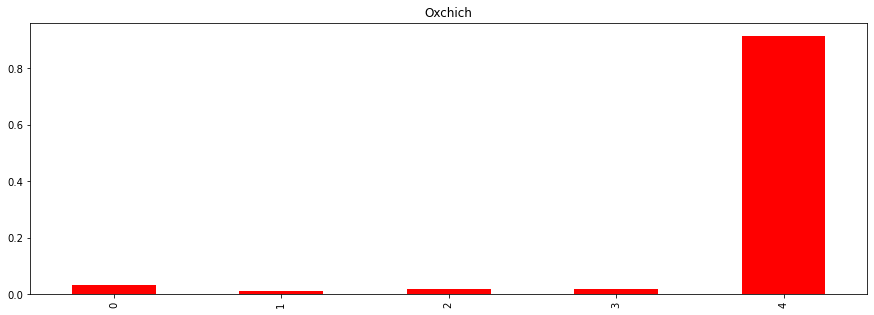

In [72]:


x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))





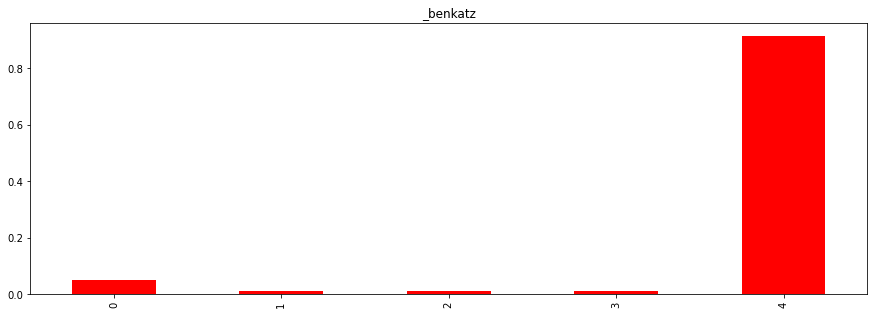

In [73]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[1]
row1.plot(kind='bar',title='_benkatz', color='r',stacked=False, figsize=(15,5))


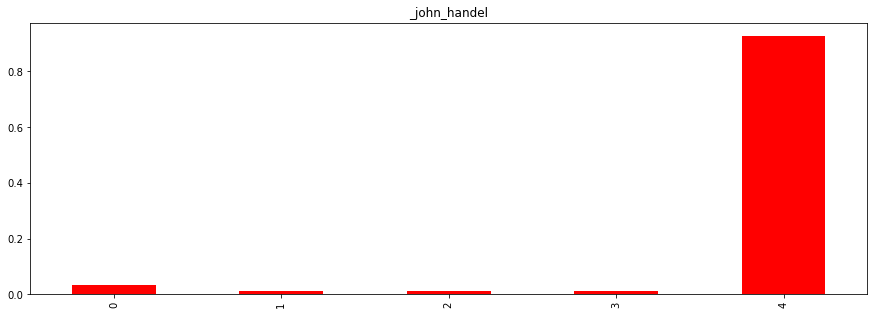

In [74]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[2]
row1.plot(kind='bar',title='_john_handel', color='r',stacked=False, figsize=(15,5))

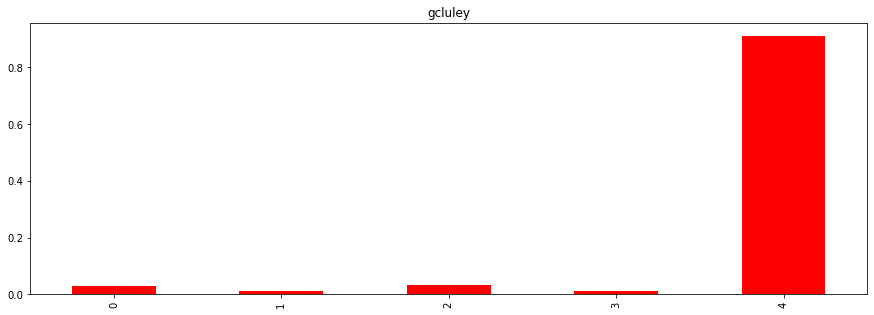

In [76]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.loc['gcluley']
row1.plot(kind='bar',title='gcluley', color='r',stacked=False, figsize=(15,5))

# Wordclouds for a sense check 

In [55]:
!pip install wordcloud


In [56]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [77]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [101]:
src_dir = r'C:\Users\elizabeth\Documents\S2DS\tweets_trained_topic_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby(['y_pred'])[['text']].sum()
        pbar.update(1)
        



Files: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [6:57:08<00:00, 625.71s/it]


In [102]:
df1.head(3).style.set_properties(subset=['text'], **{'width':'1000px'})

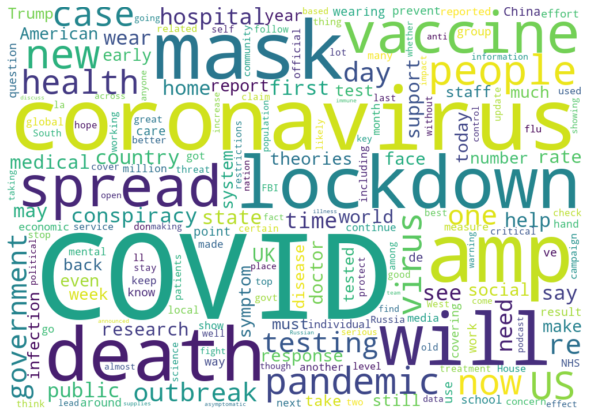

In [103]:
wordcloud_plot(df1['text'][0])


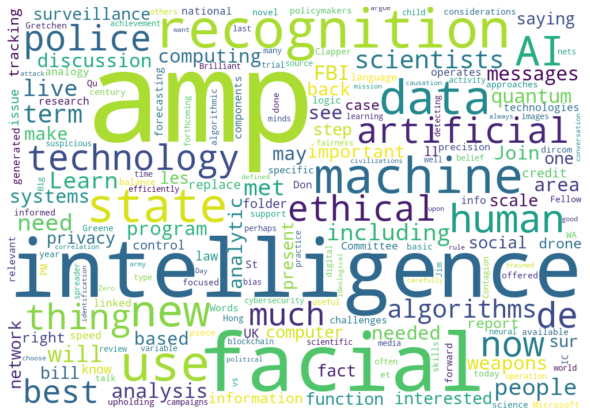

In [104]:
wordcloud_plot(df1['text'][1])

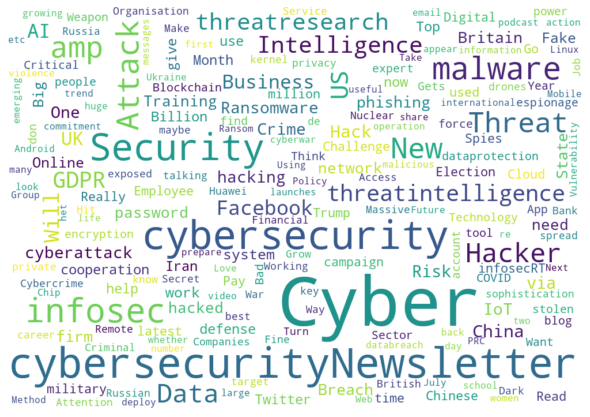

In [105]:
wordcloud_plot(df1['text'][2])

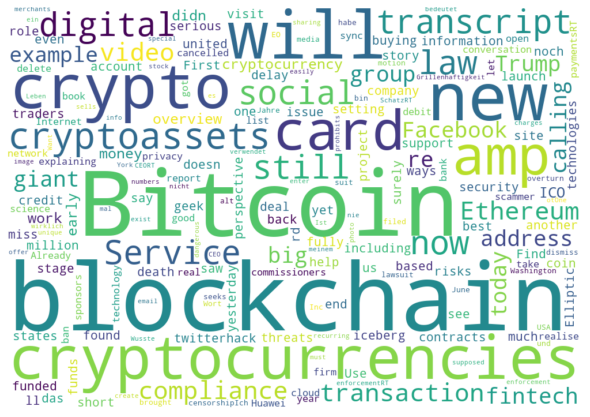

In [106]:
wordcloud_plot(df1['text'][3])

In [107]:
wordcloud_plot(df1['text'][4])

TypeError: expected string or bytes-like object

In [110]:
print(df3['0'].idxmax(), )
print(df3['1'].idxmax(), )
print(df3['2'].idxmax(), )
print(df3['3'].idxmax(), )

davidjoberly
keepnetlabs
infosec_b
autonofintech


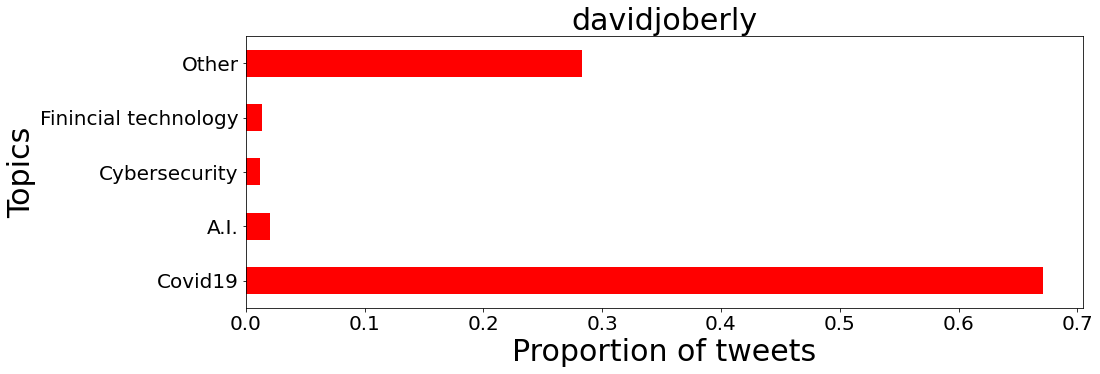

In [148]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['davidjoberly']
fig = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
fig.set_ylabel('Topics', fontsize=30)
fig.set_xlabel('Proportion of tweets', fontsize=30)
fig.set_yticklabels(labels, fontsize=20)
fig.set_xticklabels(xlabels, fontsize=20)
fig.set_title('davidjoberly', fontsize = 30 )
fig.figure.savefig('davidjoberly.png')

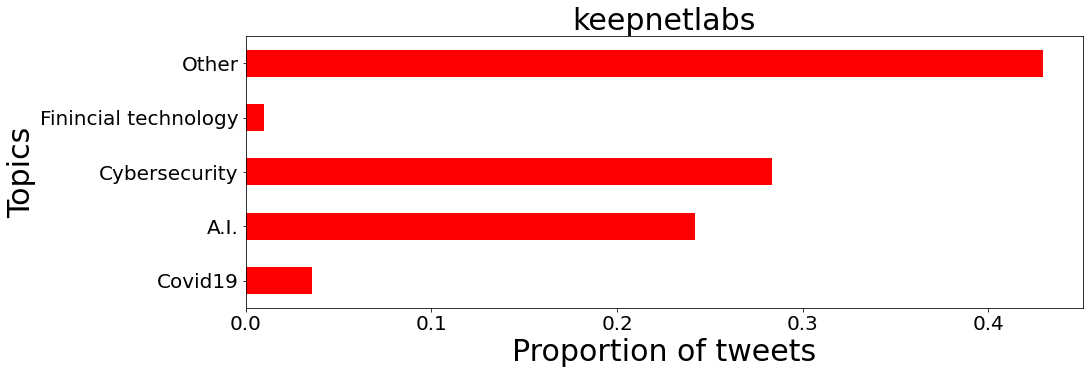

In [141]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['keepnetlabs']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('keepnetlabs', fontsize = 30 )
fig.figure.savefig('keepnetlabs.jpeg')

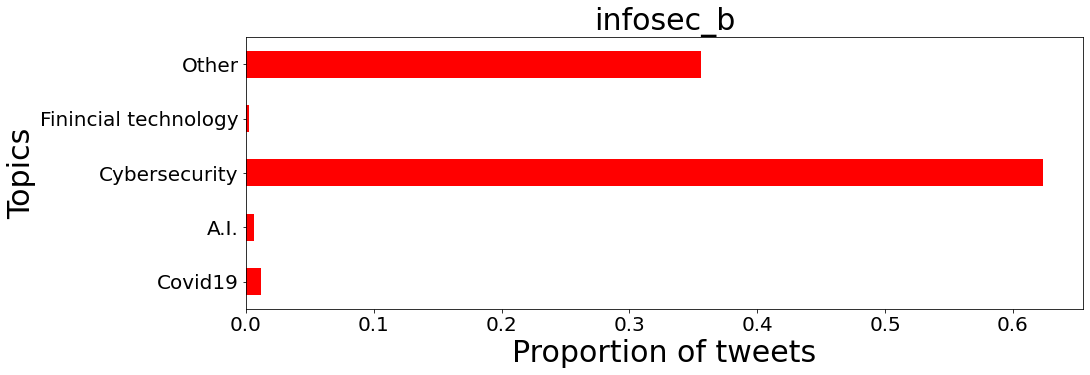

In [142]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['infosec_b']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('infosec_b', fontsize = 30 )
fig.figure.savefig('infosec_b.jpeg')

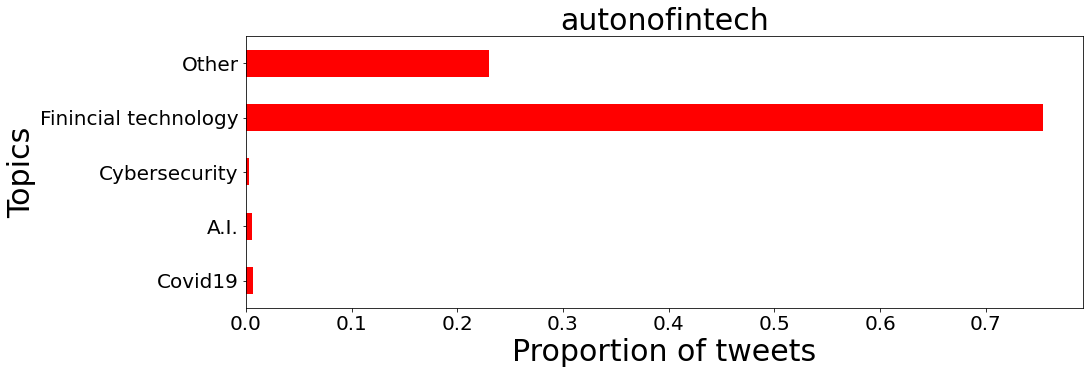

In [143]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['autonofintech']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('autonofintech', fontsize = 30 )
fig.figure.savefig('autonofintech.jpeg')